### Set up necessary data

In [18]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

# Get weights from pretrained model
weights = ResNet50_Weights.IMAGENET1K_V2

# Get transforms from weights
transform = weights.transforms()

# Load dataset CIFAR10 
train_set = datasets.CIFAR10('cifar', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10('cifar', train=False, download=True, transform=transform)

# Set up dataloader to train model in batches
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=False
)

In [19]:
# Get class name of the dataset
class_names = train_set.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
# Convert device to cuda to train by gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Modify ResNet50 model

In [21]:
# Load model and setup model
model = resnet50(weights)
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer
num_classes = len(class_names)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Convert model to device
model.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


### Retrain model

In [22]:
# Setup the
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2
# Enable train mode for model
model.train()
for epoch in range(num_epochs):
    for b, (images, labels) in enumerate(train_loader):
        # Convert data to cuda if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Split batches to print the result
        if b % 128 == 0:
          print(f"Batch: {b//128}, Loss: {loss.item()}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")


Batch: 0, Loss: 2.331516981124878
Batch: 1, Loss: 1.0829423666000366
Batch: 2, Loss: 0.7238313555717468
Batch: 3, Loss: 0.8686904907226562
Batch: 4, Loss: 0.7391788959503174
Batch: 5, Loss: 0.7733790874481201
Batch: 6, Loss: 0.5720570087432861
Epoch [1/2], Loss: 0.8208421468734741
Batch: 0, Loss: 0.5989927649497986
Batch: 1, Loss: 0.6891880631446838
Batch: 2, Loss: 0.5330284833908081
Batch: 3, Loss: 0.643700122833252
Batch: 4, Loss: 0.6366907358169556
Batch: 5, Loss: 0.6815113425254822
Batch: 6, Loss: 0.3975016474723816
Epoch [2/2], Loss: 0.6929735541343689


In [23]:
# Disable train mode for model
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Convert data to cuda if available
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy:.2f}%")

Accuracy on the test set: 79.69%


### Predict custom image

In [60]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Create function for image preprocessing
def preprocess_img(path, transform):
  img = cv2.imread(path)

  # Convert to RGB color
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Convert PIL format
  img = Image.fromarray(img)

  return img

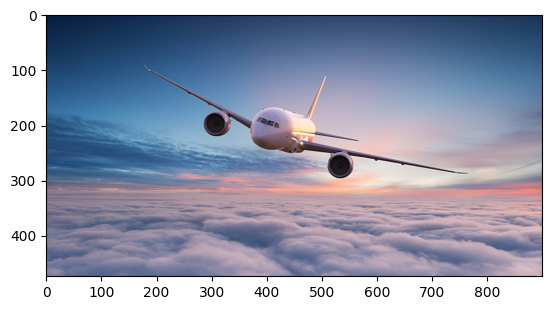

In [68]:
img_path = "data/airplane.jpg"
img = preprocess_img(img_path, transform)

plt.imshow(img);

In [69]:
# Transform image
img_trans = transform(img)
# Convert image to cuda device if available
img_cuda = img_trans.to(device)

# Predict the picture, model requires 4D data so we need to resize the image
output = model(img_cuda.reshape([1, 3, 224, 224]))

In [70]:
output

tensor([[ 2.0203, -2.5574, -0.1272, -1.9166, -3.2818, -2.1236, -6.0532, -3.3153,
         -0.8287, -3.0588]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [71]:
# Use argmax function to find which label is best fit
pred_label = torch.argmax(output)
pred = class_names[pred_label]
pred

'airplane'